In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import os

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
optima = {
    "br17":     39,
    "ft53":   6905,
    "ft70":  38673,
    "ftv33":  1286,
    "ftv35":  1473,
    "ftv38":  1530,
    "ftv44":  1613,
    "ftv47":  1776,
    "ftv55":  1608,
    "ftv64":  1839,
    "ftv70":  1950,
    "ftv90":  1579,
    "ftv100": 1788,
    "ftv110": 1958,
    "ftv120": 2166,
    "ftv130": 2307,
    "ftv140": 2420,
    "ftv150": 2611,
    "ftv160": 2683,
    "ftv170": 2755,
    "kro124p":36230,
    "p43":    5620,
    "rbg323": 1326,
    "rbg358": 1163,
    "rbg403": 2465, 
    "rbg443": 2720,
    "ry48p": 14422,
}

In [3]:
def annotate_ordering(df: pd.DataFrame) -> pd.DataFrame:
    df["instance_size"] = df.instance.apply(lambda x: int(re.search(r'\d+', x).group()))
    df["method_idx"] = df["method"].apply(lambda x: all_methods.index(x))
    return df.sort_values(by=['instance_size', 'method_idx'])

all_res_df = pd.read_json('../data/results/atsp-out-300.json')

selected_instances = all_res_df['instance'].unique()

custom_names = {
    "steepest-search": "S-R",
    "steepest-search-nn": "S-H",
    "greedy-search": "G-R",
    "greedy-search-nn": "G-H",
    "nn-heuristic": "H",
    "random-walk": "RW",
    "random": "R"
}

all_methods = list(custom_names.values())
selected_methods = [
    "S-R",
    "G-R",
    "H",
    "RW",
    "R"
]

all_res_df['method'] = all_res_df['method'].apply(lambda x: custom_names[x])
all_res_df = annotate_ordering(all_res_df).reset_index(drop=True)
all_res_df.head()

,order,cost,initial_cost,time,iterations,steps,evaluations,method,instance,instance_size,method_idx
0,"[12, 14, 15, 16, 21, 20, 25, 1, 33, 2, 3, 0, 2...",1801,4354,722730,19,18,20672,S-R,ftv33,33,0
1,"[4, 5, 6, 32, 7, 13, 1, 2, 3, 0, 9, 10, 18, 20...",1938,4247,922940,19,18,20672,S-R,ftv33,33,0
2,"[21, 26, 22, 23, 11, 8, 10, 9, 1, 27, 28, 29, ...",1874,4490,852250,17,16,18496,S-R,ftv33,33,0
3,"[21, 31, 18, 17, 11, 8, 10, 32, 7, 4, 6, 5, 30...",1512,4698,1444890,28,27,30464,S-R,ftv33,33,0
4,"[15, 16, 0, 25, 1, 29, 26, 22, 24, 23, 20, 21,...",1462,4630,1713530,34,33,36992,S-R,ftv33,33,0


In [4]:
LS_METHODS = ["S-R", "G-R"]
LS_NN_METHODS = ["S-H", "G-H"]
RANDOM_METHODS = ["R", "RW"]

In [5]:
COLORS = dict(zip(selected_methods, sns.palettes.SEABORN_PALETTES["muted"]))
COLORS["S-R"] = "#6a9ec3"
COLORS["S-H"] = "#14397E"
COLORS["G-H"] = "#76330E"

all_res_df["distance"] = all_res_df.apply(lambda row: (row['cost'] - optima[row['instance']]) / optima[row['instance']], axis=1)
groupped_df = all_res_df.groupby(['instance', 'method'])[["distance", "time", "iterations", "steps", "evaluations", 'cost']].agg(['mean', 'std', 'min', 'max'])
groupped_df.columns = ["_".join(x) for x in groupped_df.columns]
stats_df = groupped_df.reset_index()
stats_df = annotate_ordering(stats_df).reset_index(drop=True)
stats_df.head()

,instance,method,distance_mean,distance_std,distance_min,distance_max,time_mean,time_std,time_min,time_max,...,evaluations_mean,evaluations_std,evaluations_min,evaluations_max,cost_mean,cost_std,cost_min,cost_max,instance_size,method_idx
0,ftv33,S-R,0.336350,0.094218,0.077760,0.631415,1.131285e+06,187661.328320,706410,1947650,...,24353.066667,3567.616479,16320,40256,1718.546667,121.164008,1386,2098,33,0
1,ftv33,S-H,0.256778,0.055673,0.167185,0.381026,1.844695e+05,76590.878275,46650,522380,...,3924.053333,1603.658359,1088,8704,1616.216667,71.595550,1501,1776,33,1
2,ftv33,G-R,0.350570,0.097288,0.110420,0.652411,1.382510e+06,210391.266510,861790,2121200,...,4035.973333,1095.734209,2221,7673,1736.833333,125.111825,1428,2125,33,2
3,ftv33,G-H,0.257530,0.054729,0.155521,0.381026,2.060696e+05,82424.219495,82050,561800,...,1986.520000,760.490061,1088,5685,1617.183333,70.381400,1486,1776,33,3
4,ftv33,H,0.314321,0.052937,0.236392,0.413686,3.219933e+03,212.992680,2610,4150,...,0.000000,0.000000,0,0,1690.216667,68.076362,1590,1818,33,4


In [6]:
neigbourhoods = {
    "b": "both",
    "n": "node",
    "e": "edge",
}
dfs = []
for neighbourhood in neigbourhoods:
    file = f'../data/results/atsp-out-50-{neighbourhood}.json'
    df = pd.read_json(file)
    df["neighborhood"] = neigbourhoods[neighbourhood]
    dfs.append(df)

n_analysis_df = pd.concat(dfs)
n_analysis_df['method'] = n_analysis_df['method'].apply(lambda x: custom_names[x])
n_analysis_df = annotate_ordering(n_analysis_df).reset_index(drop=True)
n_analysis_df = n_analysis_df[n_analysis_df['method'].isin(LS_METHODS + LS_NN_METHODS)]
n_analysis_df["distance"] = n_analysis_df.apply(lambda row: (row['cost'] - optima[row['instance']]) / optima[row['instance']], axis=1)
n_analysis_df.head()

,order,cost,initial_cost,time,iterations,steps,evaluations,method,instance,neighborhood,instance_size,method_idx,distance
0,"[12, 14, 15, 16, 21, 20, 25, 1, 33, 2, 3, 0, 2...",1801,4354,1328420,19,18,20672,S-R,ftv33,both,33,0,0.400467
1,"[4, 5, 6, 32, 7, 13, 1, 2, 3, 0, 9, 10, 18, 20...",1938,4247,1606840,19,18,20672,S-R,ftv33,both,33,0,0.506998
2,"[18, 11, 8, 12, 14, 15, 16, 13, 9, 32, 7, 4, 6...",1641,4724,1534980,23,22,25024,S-R,ftv33,both,33,0,0.276050
3,"[20, 21, 32, 7, 8, 14, 15, 16, 26, 27, 28, 29,...",1835,4899,1526000,20,19,21760,S-R,ftv33,both,33,0,0.426905
4,"[18, 17, 13, 25, 27, 28, 33, 30, 29, 26, 22, 2...",1698,4492,1843190,23,22,25024,S-R,ftv33,both,33,0,0.320373


In [7]:
n_groupped_df = n_analysis_df.groupby(['instance', 'method', 'neighborhood'])[["distance", "time", "iterations", "steps", "evaluations", 'cost']].agg(['mean', 'std', 'min', 'max'])
n_groupped_df.columns = ["_".join(x) for x in n_groupped_df.columns]
n_stats_df = n_groupped_df.reset_index()
n_stats_df = annotate_ordering(n_stats_df).reset_index(drop=True)
n_stats_df.head()

,instance,method,neighborhood,distance_mean,distance_std,distance_min,distance_max,time_mean,time_std,time_min,...,evaluations_mean,evaluations_std,evaluations_min,evaluations_max,cost_mean,cost_std,cost_min,cost_max,instance_size,method_idx
0,ftv33,S-R,both,0.339238,0.094663,0.196734,0.614308,1728829.2,444722.596035,1123490,...,24262.40,3606.813688,19584,38080,1722.26,121.736385,1539,2076,33,0
1,ftv33,S-R,edge,0.632519,0.157003,0.337481,0.990669,1130194.0,260210.527968,483420,...,10814.04,2269.186863,6324,15810,2099.42,201.905422,1720,2560,33,0
2,ftv33,S-R,node,0.427061,0.099481,0.216952,0.635303,303680.8,49720.608212,216460,...,12431.44,1667.316066,7868,16860,1835.20,127.932859,1565,2103,33,0
3,ftv33,S-H,both,0.254292,0.053023,0.167185,0.381026,293388.0,121496.604723,82270,...,4069.12,1519.865738,1088,8704,1613.02,68.187763,1501,1776,33,1
4,ftv33,S-H,edge,0.263079,0.062984,0.171851,0.413686,196064.6,83442.705926,40680,...,1802.34,722.821276,527,3162,1624.32,80.997969,1507,1818,33,1


In [8]:
def plot_violin_by_attr(
        res_df: pd.DataFrame, 
        selected_methods: list[str],
        selected_instances: list[str], 
        attribute: str,
        ax: plt.Axes,
        y_max: int = None,
    ):
    filtered_df = res_df[res_df['method'].isin(selected_methods) & res_df['instance'].isin(selected_instances)]
    sns.violinplot(
        x='instance', 
        y=attribute, 
        hue='method', 
        data=filtered_df, 
        ax=ax,
        linewidth=0, 
        scale='width', 
        palette=COLORS, 
    )
    ax.vlines(
        np.arange(-1, len(selected_instances)) + 0.5, 
        0, 
        filtered_df[attribute].max() if y_max is None else y_max, 
        linestyles='dotted', 
        colors='gray', 
        alpha=0.5,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax


def plot_bars(
    res_df: pd.DataFrame,
    selected_methods: list[str],
    selected_instances: list[str],
    attribute: str,
    ax: plt.Axes,
    err_attribute: str = None,
    x_attr: str = 'instance',
):
    filtered_df = res_df[res_df['method'].isin(selected_methods) & res_df['instance'].isin(selected_instances)]
    sns.barplot(
        x=x_attr, 
        y=attribute, 
        hue='method',
        data=filtered_df, 
        ax=ax,
        palette=COLORS,
    )
    if err_attribute:
        x_coords = np.array([p.get_x() + p.get_width() / 2 for p in ax.patches])
        y_coords = np.array([p.get_height() for p in ax.patches])
        sorted_idx = np.argsort(x_coords)
        x_coords = x_coords[sorted_idx]
        y_coords = y_coords[sorted_idx]
        ax.errorbar(x_coords, y_coords, yerr=filtered_df[err_attribute].to_numpy(), fmt='none', ecolor='black', capsize=2)


    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

In [9]:
sns.set_style("ticks")

## 1. Quality (distance from the optimum)

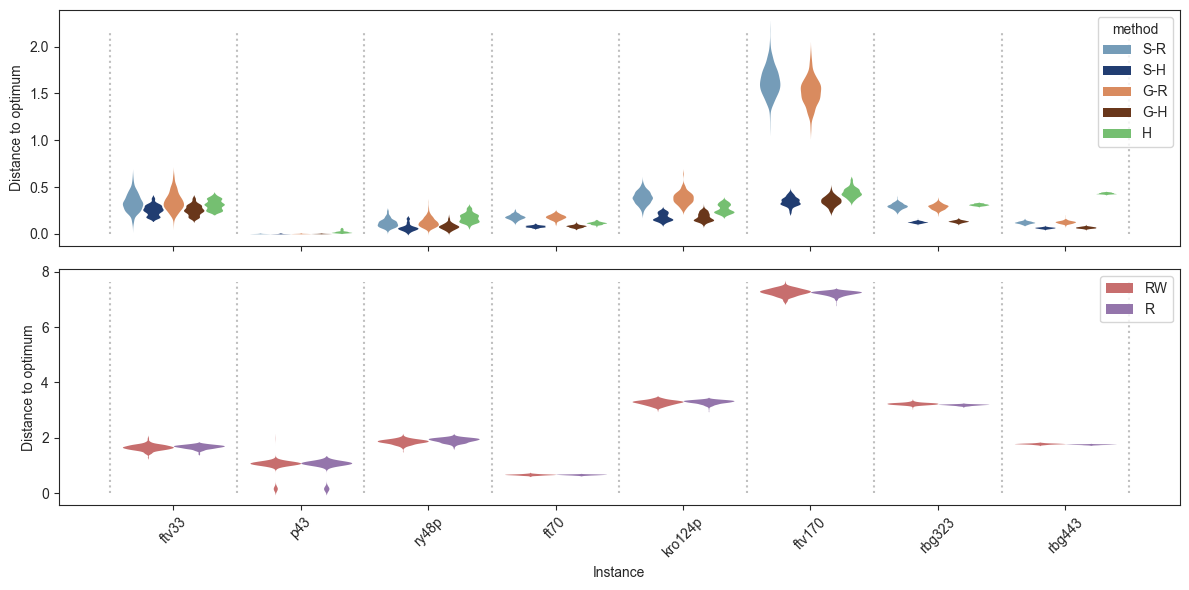

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plot_violin_by_attr(all_res_df, [*LS_METHODS, *LS_NN_METHODS, "H"], selected_instances, "distance", axs[0])
plot_violin_by_attr(all_res_df, RANDOM_METHODS, selected_instances, "distance", axs[1])
axs[0].set_xlabel("")
axs[0].set_ylabel("Distance to optimum")
axs[1].set_ylabel("Distance to optimum")
axs[1].set_xlabel("Instance")
axs[1].legend()

plt.tight_layout()
plt.savefig("plots/1/violin_distance.png")
plt.show()

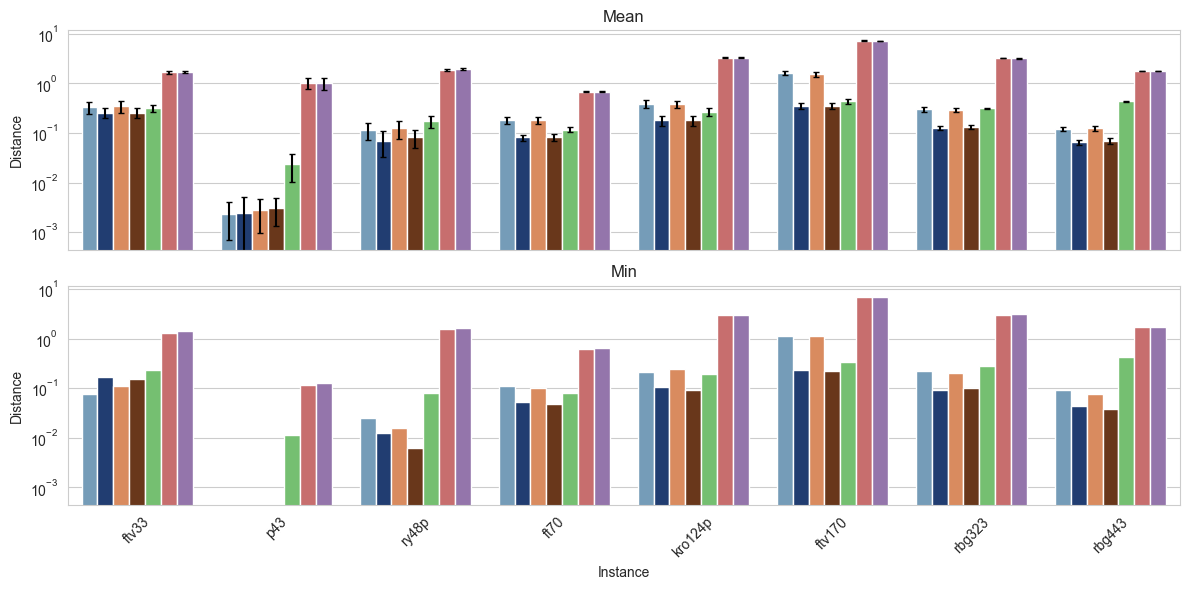

In [11]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharey=True, sharex=True)
    plot_bars(stats_df, [*selected_methods, *LS_NN_METHODS], selected_instances, "distance_mean", axs[0], "distance_std")
    axs[0].set_ylabel("Distance")
    axs[0].set_xlabel("")
    axs[0].set_title("Mean")
    axs[0].legend().remove()
    plot_bars(stats_df, [*selected_methods, *LS_NN_METHODS], selected_instances, "distance_min", axs[1])
    axs[1].legend().remove()
    axs[1].set_ylabel("Distance")
    axs[1].set_xlabel("Instance")
    axs[1].set_title("Min")
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig("plots/1/bar_distance.png")
    plt.show()

#Consider reducing space by shorter abbreviation

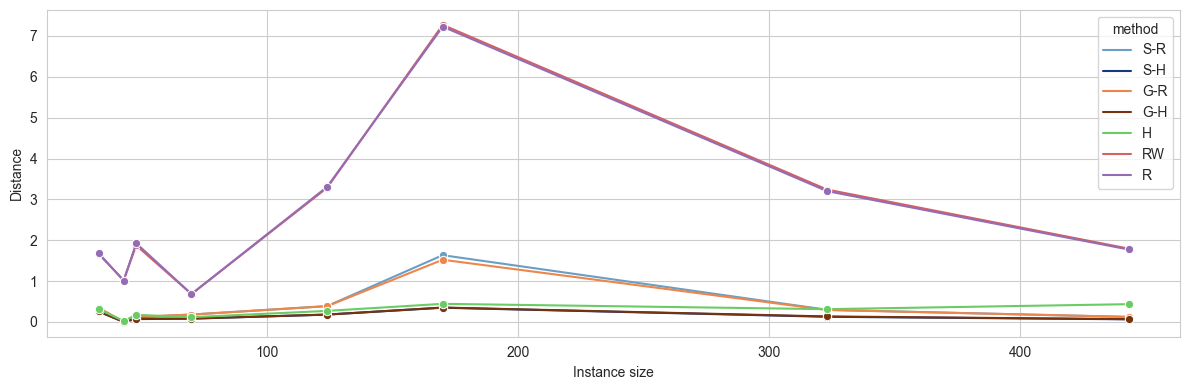

In [12]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    sns.lineplot(
        x='instance_size',
        y='distance_mean',
        hue='method',
        data=stats_df[stats_df['method'].isin(all_methods)],
        ax=ax,
        palette=COLORS,
        marker="o"
    )
    ax.set_ylabel("Distance")
    ax.set_xlabel("Instance size")

    plt.tight_layout()
    plt.savefig("plots/1/line_distance.png")
    plt.show()

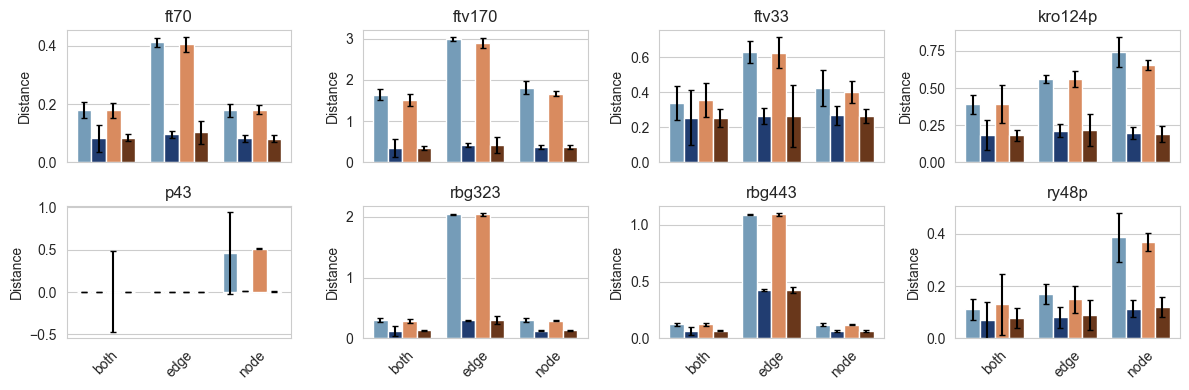

In [13]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2, 4, figsize=(12, 4), sharex=True, sharey=False)
    for instance, ax in zip(selected_instances, axs.flatten()):
        plot_bars(n_stats_df, LS_METHODS + LS_NN_METHODS, [instance], "distance_mean", ax, "distance_std", "neighborhood") 
        ax.set_title(instance)
        ax.set_ylabel("Distance")
        ax.set_xlabel("")
        ax.legend().remove()

    plt.tight_layout()
    plt.savefig("plots/1/bar_distance_neighborhood.png")
    plt.show()

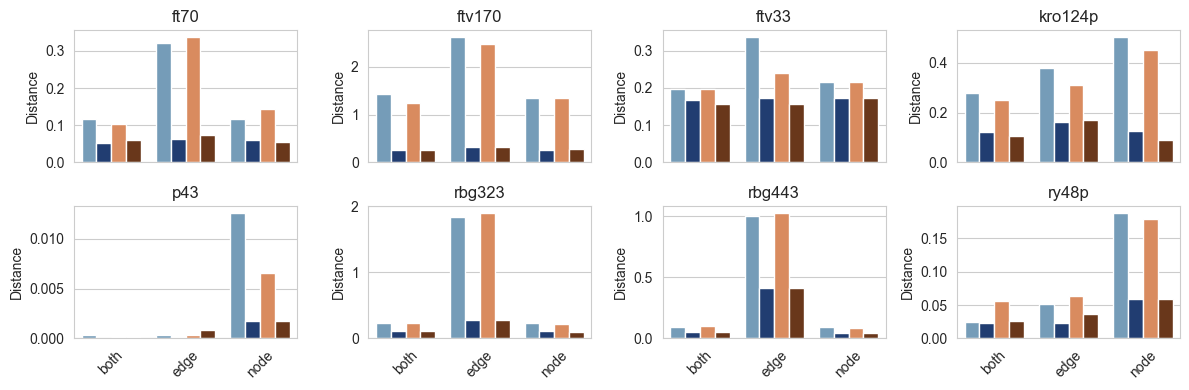

In [41]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2, 4, figsize=(12, 4), sharex=True, sharey=False)
    for instance, ax in zip(selected_instances, axs.flatten()):
        plot_bars(n_stats_df, LS_METHODS + LS_NN_METHODS, [instance], "distance_min", ax, None, "neighborhood") 
        ax.set_title(instance)
        ax.set_ylabel("Distance")
        ax.set_xlabel("")
        ax.legend().remove()

    plt.tight_layout()
    plt.savefig("plots/1/bar_min_distance_neighborhood.png")
    plt.show()

# 2. Time

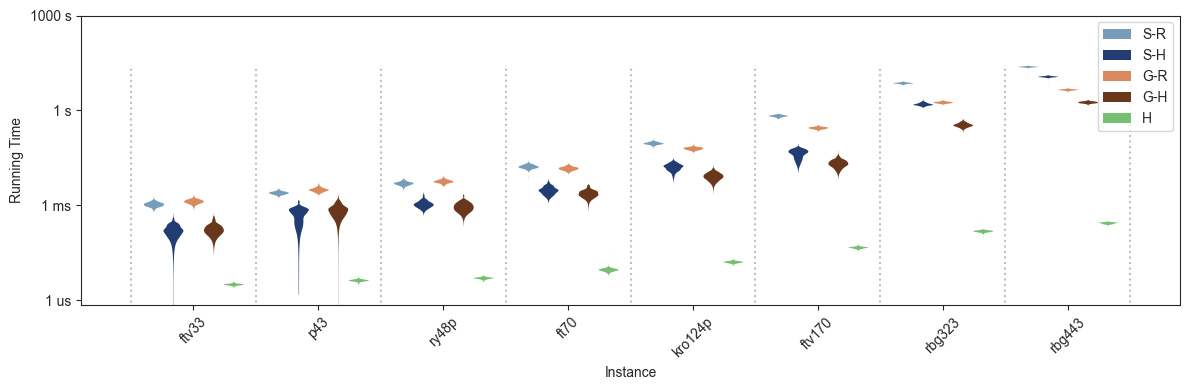

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_violin_by_attr(all_res_df, [*LS_METHODS, *LS_NN_METHODS, "H"], selected_instances, "time", ax)

ax.legend()
ax.set_ylabel("Running Time")
ax.set_xlabel("Instance")
plt.yscale('log')
plt.yticks([10**i for i in range(3, 13, 3)], ["1 us", "1 ms", "1 s", "1000 s"])
plt.tight_layout()
plt.savefig("plots/1/violin_time.png")
plt.show()

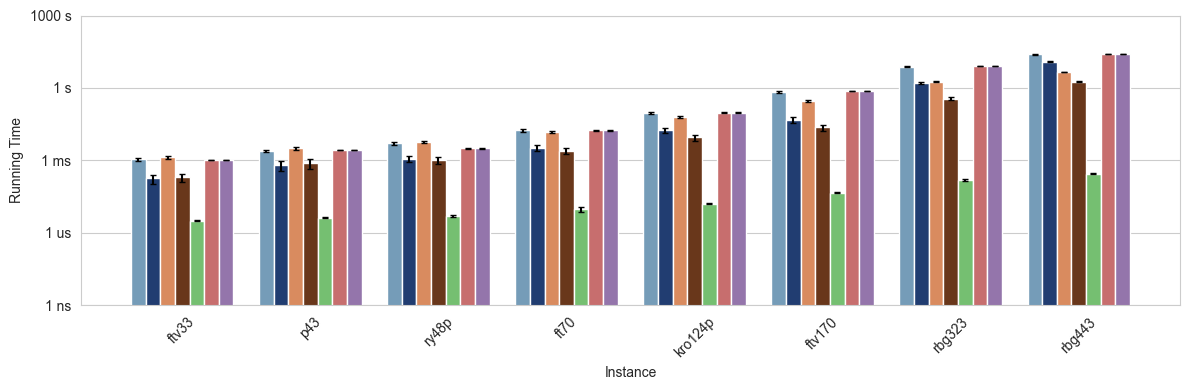

In [15]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plot_bars(stats_df, selected_methods + LS_NN_METHODS, selected_instances, "time_mean", ax, "time_std")
    ax.set_ylabel("Running Time")
    ax.set_xlabel("Instance")
    ax.get_legend().remove()
    
    plt.yscale('log')
    plt.yticks([10**i for i in range(0, 13, 3)], ["1 ns", "1 us", "1 ms", "1 s", "1000 s"])
    plt.tight_layout()
    plt.savefig("plots/1/bar_time.png")
    plt.show()

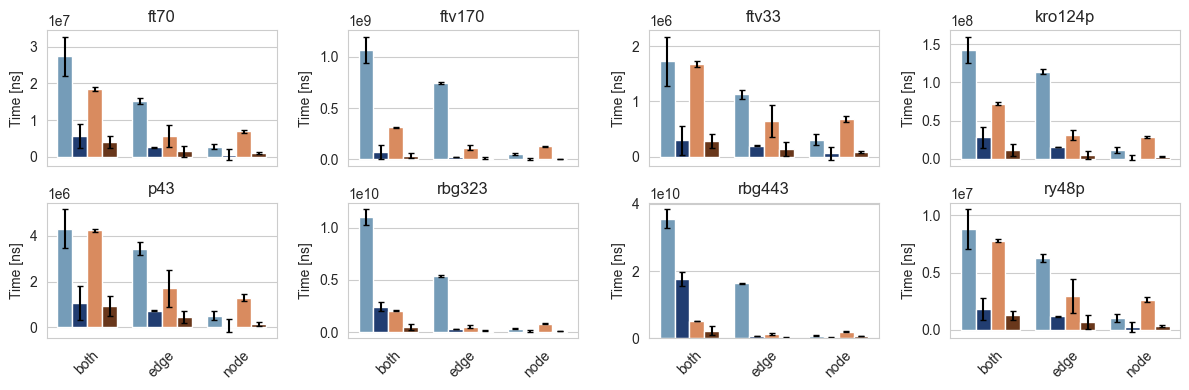

In [16]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2, 4, figsize=(12, 4), sharex=True, sharey=False)
    for instance, ax in zip(selected_instances, axs.flatten()):
        plot_bars(n_stats_df, LS_METHODS + LS_NN_METHODS, [instance], "time_mean", ax, "time_std", "neighborhood") 
        ax.set_title(instance)
        ax.set_ylabel("Time [ns]")
        ax.set_xlabel("")
        ax.legend().remove()

    plt.tight_layout()
    plt.savefig("plots/1/bar_time_neighborhood.png")
    plt.show()

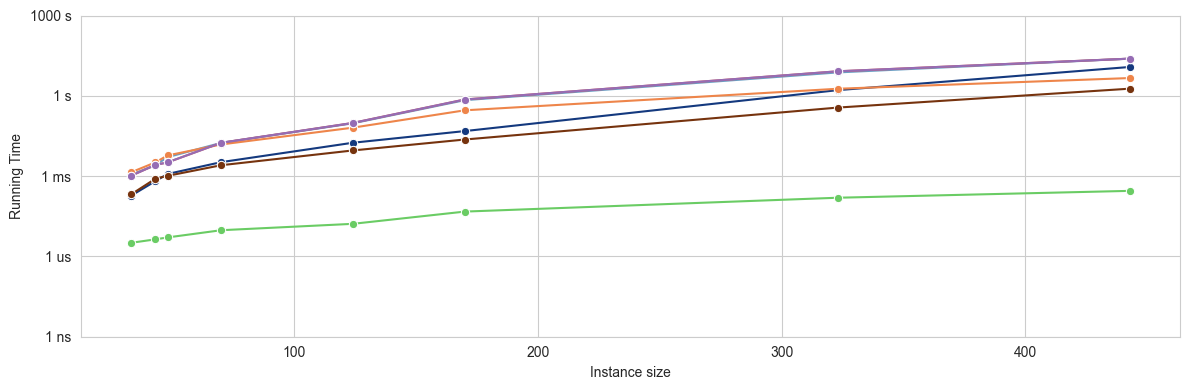

In [17]:
# plot mean time over instance size for each method
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    sns.lineplot(
        x='instance_size',
        y='time_mean',
        hue='method',
        data=stats_df[stats_df['method'].isin(all_methods)],
        ax=ax,
        palette=COLORS,
        marker="o"
    )
    ax.set_ylabel("Running Time")
    ax.set_xlabel("Instance size")
    ax.set_yscale('log')
    ax.set_yticks([10**i for i in range(0, 13, 3)], ["1 ns", "1 us", "1 ms", "1 s", "1000 s"])
    ax.legend().remove()
    # plot mean distance over instance size for each method
    # highligh points as dots
    plt.tight_layout()
    plt.savefig("plots/1/line_time.png")
    plt.show()

# 3. Efficiency of algorithms

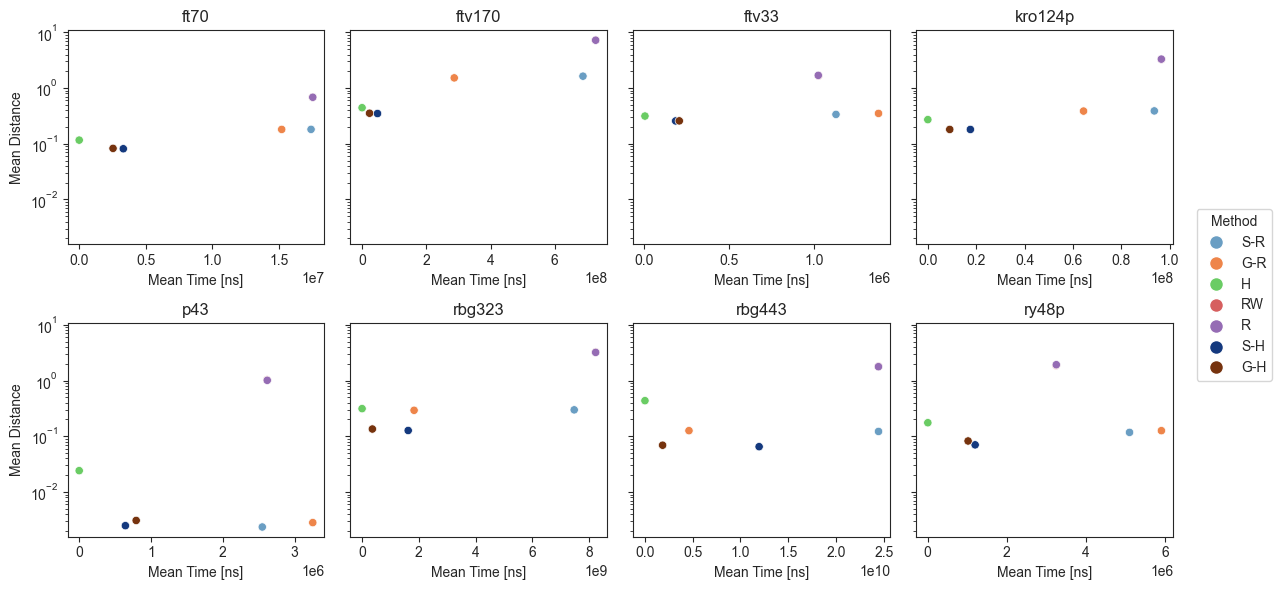

In [18]:
# plot mean time over mean distance for each method
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharey=True)

for instance, ax in zip(selected_instances, axs.flatten()):
    summary_subset_df = stats_df[(stats_df['instance'] == instance) & (stats_df['method'].isin(selected_methods + LS_NN_METHODS))]
    sns.scatterplot(
        x='time_mean',
        y='distance_mean',
        hue='method',
        data=summary_subset_df,
        ax=ax,
        alpha=1,
        palette=COLORS,
    )

    ax.set_xlabel("Mean Time [ns]")
    ax.set_ylabel("Mean Distance")
    ax.set_title(instance)
    ax.set_yscale('log')
    ax.get_legend().remove()


lgd = fig.legend(
    handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS[method], markersize=10, label=method) for method in selected_methods + LS_NN_METHODS],
    loc='center right',
    bbox_to_anchor=(1.07, 0.5),
    title="Method"
)
plt.tight_layout()
fig.savefig("plots/1/efficiency.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

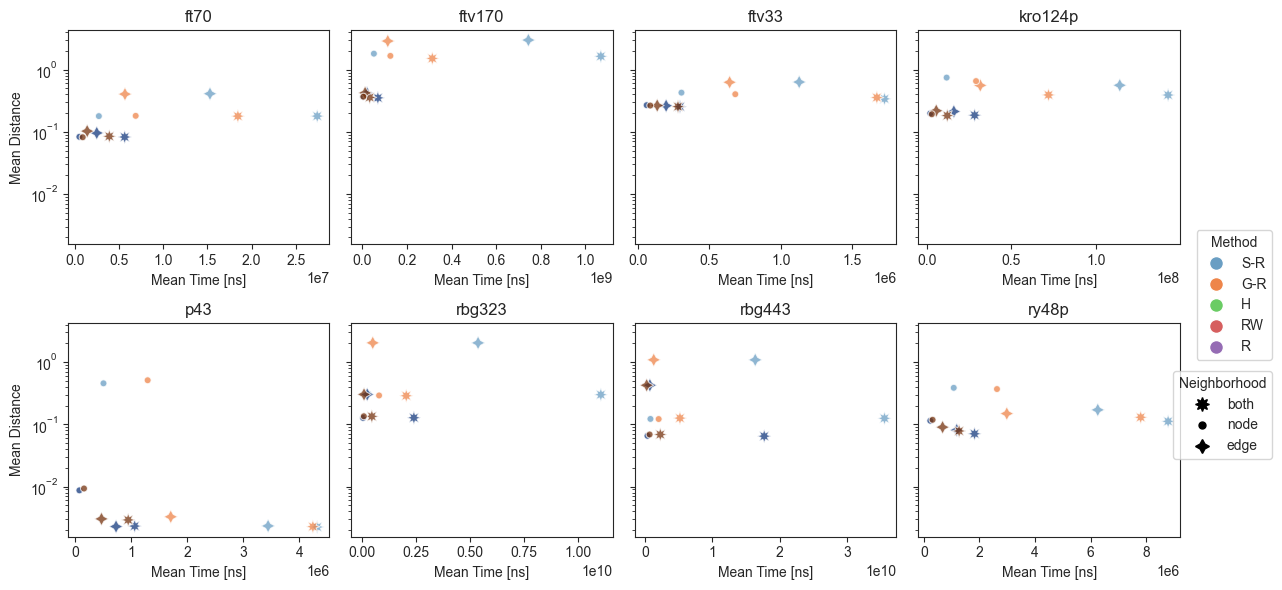

In [19]:
# plot mean time over mean distance for each method
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharey=True)
markers = {
    "node": '.',
    "edge": (4, 1, 0),
    "both": (8, 1, 0),
}
for instance, ax in zip(selected_instances, axs.flatten()):
    sns.scatterplot(
        x='time_mean',
        y='distance_mean',
        hue='method',
        style='neighborhood',
        markers=markers,
        s=100,
        data=n_stats_df[(n_stats_df['instance'] == instance)],
        ax=ax,
        alpha=0.75,
        palette=COLORS,
    )

    ax.set_xlabel("Mean Time [ns]")
    ax.set_ylabel("Mean Distance")
    ax.set_title(instance)
    ax.set_yscale('log')
    ax.get_legend().remove()

lgd = fig.legend(
    handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS[method], markersize=10, label=method) for method in selected_methods],
    loc='center right',
    bbox_to_anchor=(1.07, 0.5),
    title="Method"
)
lgd_2 = fig.legend(
    handles=[plt.Line2D([0], [0], marker=markers[neighbourhood], color='w', markerfacecolor='black', markeredgecolor="black", markersize=10, label=neighbourhood) for neighbourhood in neigbourhoods.values()],
    loc='center right',
    bbox_to_anchor=(1.07, 0.3),
    title="Neighborhood"
)

plt.tight_layout()
fig.savefig("plots/1/efficiency-neighborhood.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# 4. Number of steps

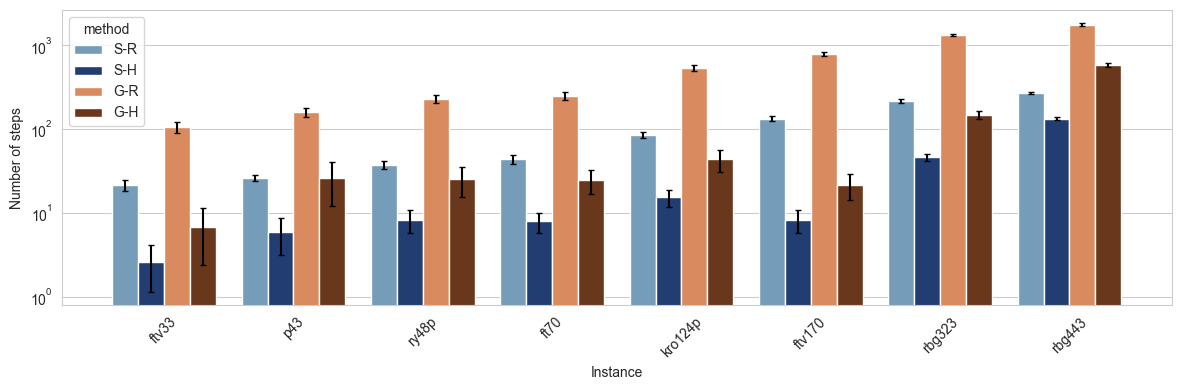

In [20]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plot_bars(stats_df, LS_METHODS + LS_NN_METHODS, selected_instances, "steps_mean", ax, "steps_std")
    ax.set_ylabel("Number of steps")
    ax.set_xlabel("Instance")
    plt.tight_layout()
    plt.yscale('log')
    plt.savefig("plots/1/bar_steps.png")
    plt.show()

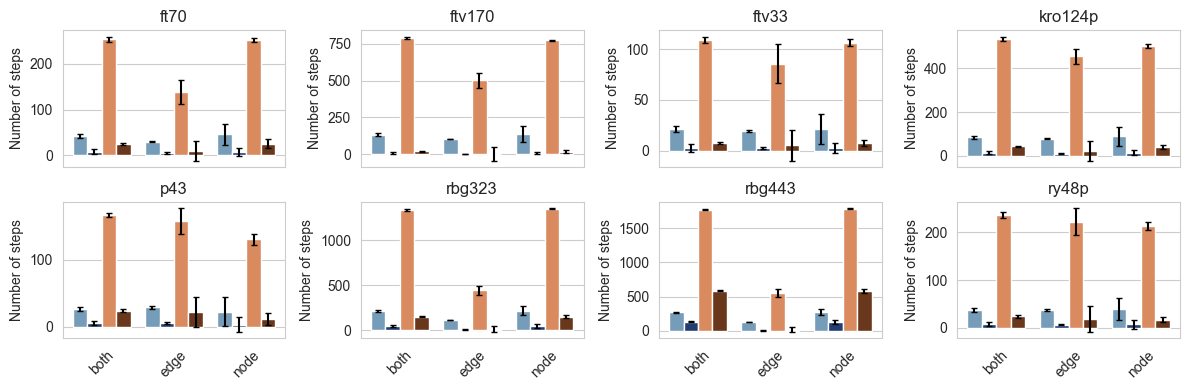

In [21]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2, 4, figsize=(12, 4), sharex=True, sharey=False)
    for instance, ax in zip(selected_instances, axs.flatten()):
        plot_bars(n_stats_df, LS_METHODS + LS_NN_METHODS, [instance], "steps_mean", ax, "steps_std", "neighborhood") 
        ax.set_title(instance)
        ax.set_ylabel("Number of steps")
        ax.set_xlabel("")
        ax.legend().remove()

    plt.tight_layout()
    plt.savefig("plots/1/bar_steps_neighborhood.png")
    plt.show()

# 5. Number of evaluations

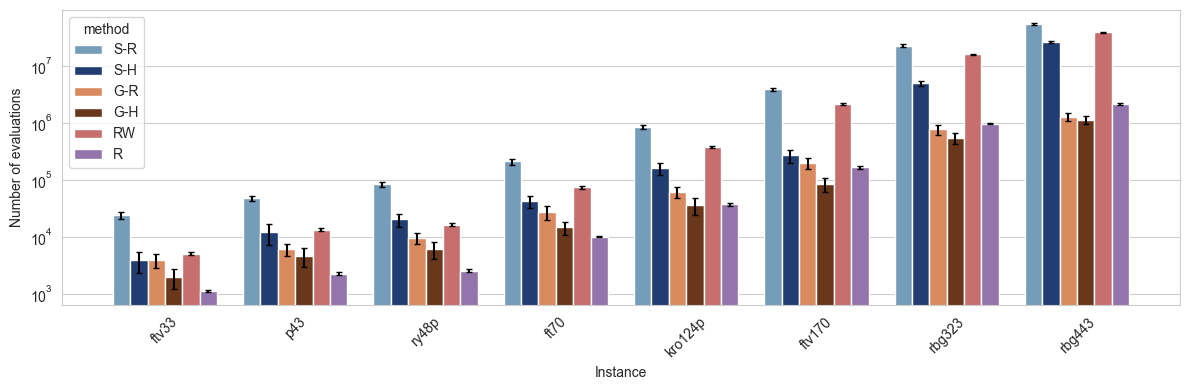

In [22]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plot_bars(stats_df, [*LS_METHODS, *LS_NN_METHODS, *RANDOM_METHODS], selected_instances, "evaluations_mean", ax, "evaluations_std")
    ax.set_ylabel("Number of evaluations")
    ax.set_xlabel("Instance")
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig("plots/1/bar_evaluations.png")
    plt.show()

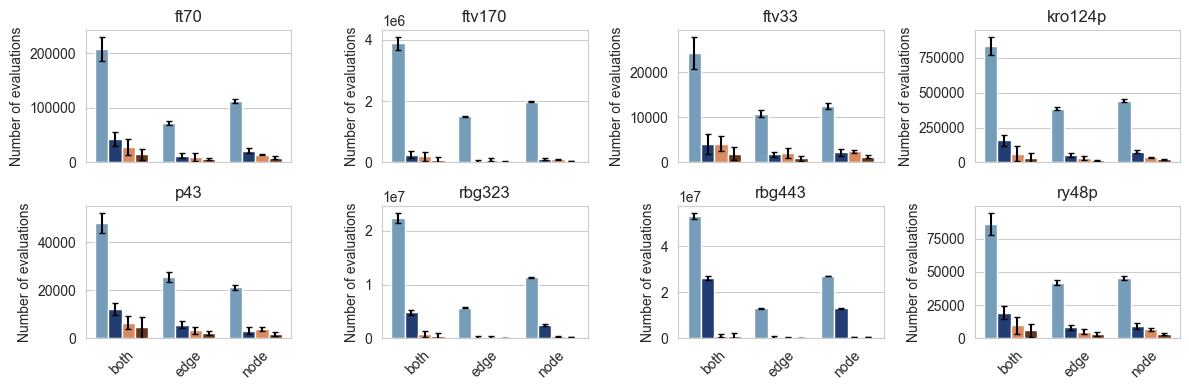

In [23]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2, 4, figsize=(12, 4), sharex=True, sharey=False)
    for instance, ax in zip(selected_instances, axs.flatten()):
        plot_bars(n_stats_df, LS_METHODS + LS_NN_METHODS, [instance], "evaluations_mean", ax, "evaluations_std", "neighborhood") 
        ax.set_title(instance)
        ax.set_ylabel("Number of evaluations")
        ax.set_xlabel("")
        ax.legend().remove()

    plt.tight_layout()
    plt.ylabel("Number of evaluations")
    plt.savefig("plots/1/bar_evaluations_neighborhood.png")
    plt.show()

# 6. Quality Improvement

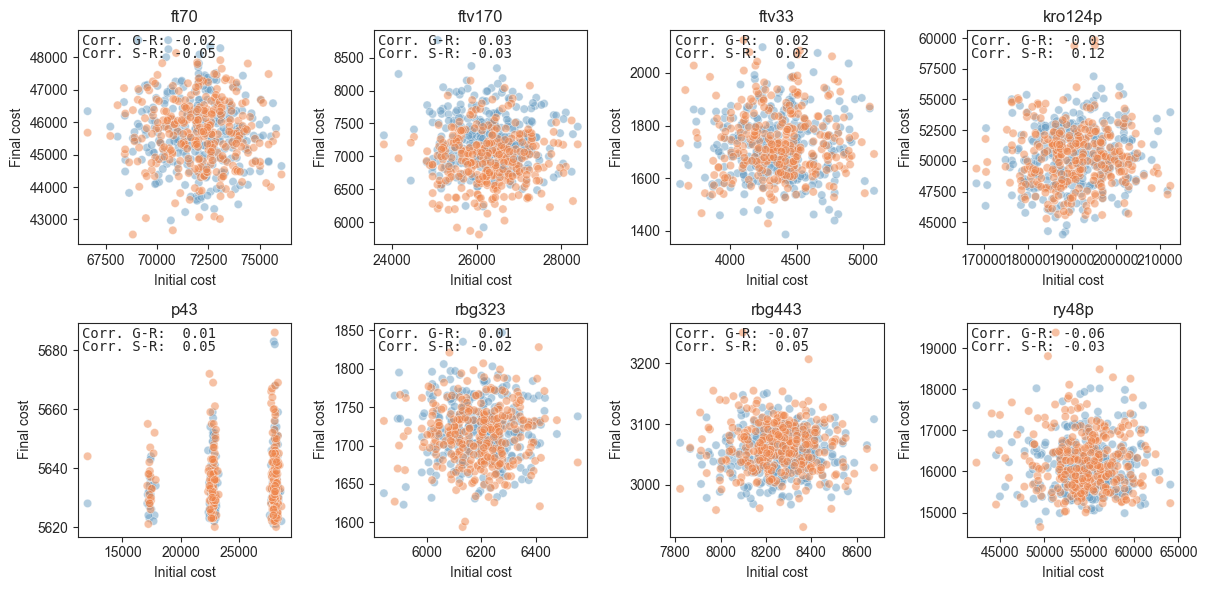

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))#, sharex=True, sharey=True)
finit_correlation_dict = {
    instance: {} for instance in selected_instances
}
for instance, ax in zip(selected_instances, axs.flatten()):
    subset_df = all_res_df[(all_res_df['instance'] == instance) & (all_res_df['method'].isin(LS_METHODS))] 
    sns.scatterplot(
        x='initial_cost',
        y='cost',
        hue='method',
        data=subset_df,
        ax=ax,
        palette=COLORS,
        alpha=0.5,
    )
    for i, (method, method_df) in enumerate(subset_df.groupby('method')):
        x = method_df['initial_cost']
        y = method_df['cost']
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        # add box with correlation
        corr_value = np.corrcoef(x, y)[0, 1]
        finit_correlation_dict[instance][method] = corr_value
        ax.text(0.02, 0.93 - 0.06 * i, f"Corr. {(method+':'):<4} {corr_value:>5.2f}", transform=ax.transAxes, fontsize=10, font="monospace")
    ax.set_xlabel("Initial cost")
    ax.set_ylabel("Final cost")
    ax.set_title(instance)
    ax.get_legend().remove()

plt.tight_layout()
plt.savefig("plots/1/scatter_initial_final_cost_random_init.png")
plt.show()

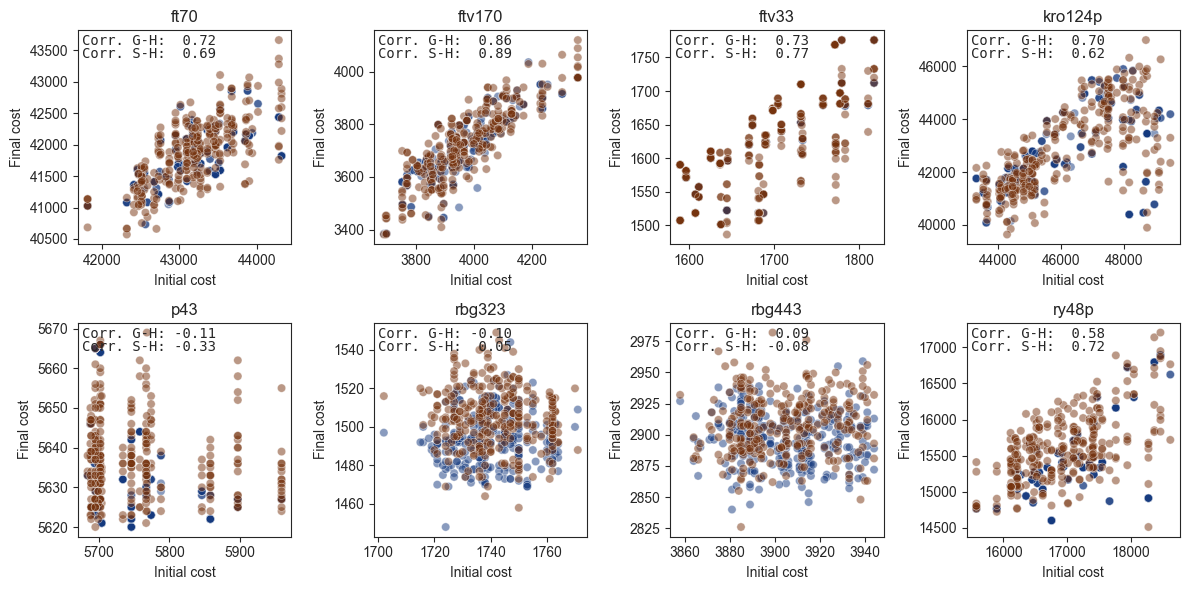

In [25]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))#, sharex=True, sharey=True)
line_colors = sns.color_palette("muted", len(selected_methods))

for instance, ax in zip(selected_instances, axs.flatten()):
    subset_df = all_res_df[(all_res_df['instance'] == instance) & (all_res_df['method'].isin(LS_NN_METHODS))]
    sns.scatterplot(
        x='initial_cost',
        y='cost',
        hue='method',
        data=subset_df,
        ax=ax,
        palette=COLORS,
        alpha=0.5
    )
    
    for i, (method, method_df) in enumerate(subset_df.groupby('method')):
        x = method_df['initial_cost']
        y = method_df['cost']
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        # add box with correlation
        corr_value = np.corrcoef(x, y)[0, 1]
        finit_correlation_dict[instance][method] = corr_value
        ax.text(0.02, 0.93 - 0.06 * i, f"Corr. {(method+':'):<4} {corr_value:>5.2f}", transform=ax.transAxes, fontsize=10, font="monospace")

    ax.set_title(instance)
    ax.get_legend().remove()
    ax.set_xlabel("Initial cost")
    ax.set_ylabel("Final cost")

plt.tight_layout()
plt.savefig("plots/1/scatter_initial_final_cost_nn_init.png")
plt.show()

In [26]:
finit_sim_df = pd.DataFrame(finit_correlation_dict).round(2)
finit_sim_df.sort_index(inplace=True)
finit_sim_df

,ft70,ftv170,ftv33,kro124p,p43,rbg323,rbg443,ry48p
G-H,0.72,0.86,0.73,0.70,-0.11,-0.10,0.09,0.58
G-R,-0.02,0.03,0.02,-0.03,0.01,0.01,-0.07,-0.06
S-H,0.69,0.89,0.77,0.62,-0.33,0.05,-0.08,0.72
S-R,-0.05,-0.03,0.02,0.12,0.05,-0.02,0.05,-0.03


In [27]:
print(finit_sim_df.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  ft70 &  ftv170 &  ftv33 &  kro124p &   p43 &  rbg323 &  rbg443 &  ry48p \\
\midrule
G-H &  0.72 &    0.86 &   0.73 &     0.70 & -0.11 &   -0.10 &    0.09 &   0.58 \\
G-R & -0.02 &    0.03 &   0.02 &    -0.03 &  0.01 &    0.01 &   -0.07 &  -0.06 \\
S-H &  0.69 &    0.89 &   0.77 &     0.62 & -0.33 &    0.05 &   -0.08 &   0.72 \\
S-R & -0.05 &   -0.03 &   0.02 &     0.12 &  0.05 &   -0.02 &    0.05 &  -0.03 \\
\bottomrule
\end{tabular}



C:\Users\sbart\AppData\Local\Temp\ipykernel_16996\1647817575.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(finit_sim_df.to_latex())


# 7. Number of restarts

In [28]:
running_cost_df = all_res_df[all_res_df["method"].isin(LS_METHODS + LS_NN_METHODS)].reset_index(drop=True)

running_min_cost = np.zeros(len(running_cost_df),)
running_avg_cost = np.zeros(len(running_cost_df),)

for instance in selected_instances:
    for method in LS_METHODS + LS_NN_METHODS:
        idx = running_cost_df[(running_cost_df["instance"] == instance) & (running_cost_df["method"] == method)].index
        running_min_cost[idx] = running_cost_df[(running_cost_df["instance"] == instance) & (running_cost_df["method"] == method)]["cost"].cummin()
        running_avg_cost[idx] = running_cost_df[(running_cost_df["instance"] == instance) & (running_cost_df["method"] == method)]["cost"].expanding().mean()

running_cost_df["running_min_cost"] = running_min_cost
running_cost_df["running_avg_cost"] = running_avg_cost
# make a column that counts consecutive instance-method pairs
running_cost_df["count"] = running_cost_df.groupby(['instance', 'method']).cumcount()

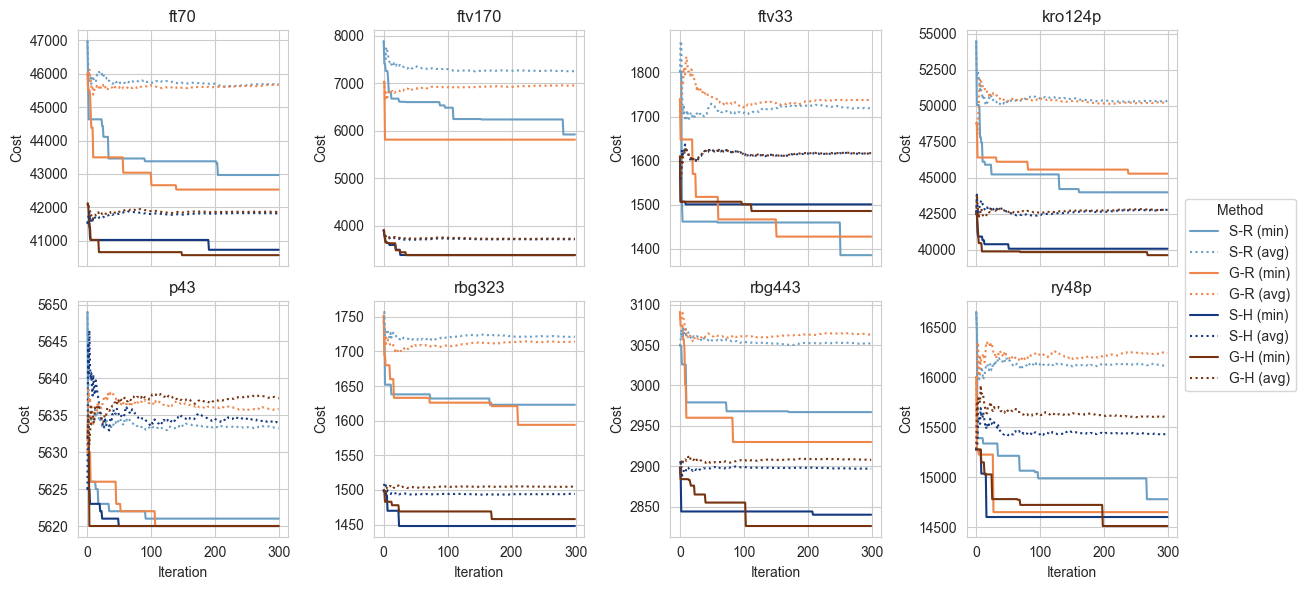

In [29]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True)

    for instance, ax in zip(selected_instances, axs.flatten()):
        subset_df = running_cost_df[(running_cost_df["instance"] == instance) & running_cost_df["method"].isin(LS_METHODS + LS_NN_METHODS)]

        
        sns.lineplot(
            x=subset_df["count"],
            y=subset_df['running_min_cost'],
            hue=subset_df["method"],
            ax=ax,
            palette=COLORS,
        )
        sns.lineplot(
            x=subset_df["count"],
            y=subset_df['running_avg_cost'],
            hue=subset_df['method'],
            ax=ax,
            palette=COLORS,
            linestyle='dotted',
        ) 
        ax.set_ylabel("Cost")
        ax.set_xlabel("Iteration")
        
        ax.set_title(instance)
        ax.get_legend().remove()

    legend_elements = []
    for method in LS_METHODS + LS_NN_METHODS:
        legend_elements.append(plt.Line2D([0], [0], color=COLORS[method], label=f"{method} (min)"))
        legend_elements.append(plt.Line2D([0], [0], color=COLORS[method], linestyle='dotted', label=f"{method} (avg)"))

    lgd = fig.legend(
        handles=legend_elements,
        loc='center right',
        bbox_to_anchor=(1.09, 0.5),
        title="Method"
    )
    plt.tight_layout()
    plt.savefig("plots/1/line_running_cost.png", bbox_inches='tight', bbox_extra_artists=(lgd,))
    plt.show()

# 8. Best solutions

In [30]:
best_costs = all_res_df.groupby("instance")["cost"].min()
best_entries = all_res_df[all_res_df["cost"].isin(best_costs)].groupby("instance").first()

best_orders = best_entries.order.to_dict()
best_costs = best_entries.cost.to_dict()

best_dict = {
    k: {"order": best_orders[k], "cost": best_costs[k]} for k in best_orders
}

In [31]:
def similarity(order_a: list[int], order_b: list[int]) -> float:
    edges_a = set(zip(order_a, [*order_a[1:], order_a[0]]))
    edges_b = set(zip(order_b, [*order_b[1:], order_b[0]]))
    return len(edges_a & edges_b) / len(order_a)

all_res_df["similarity"] = all_res_df.apply(lambda row: similarity(row["order"], best_dict[row["instance"]]["order"]), axis=1)

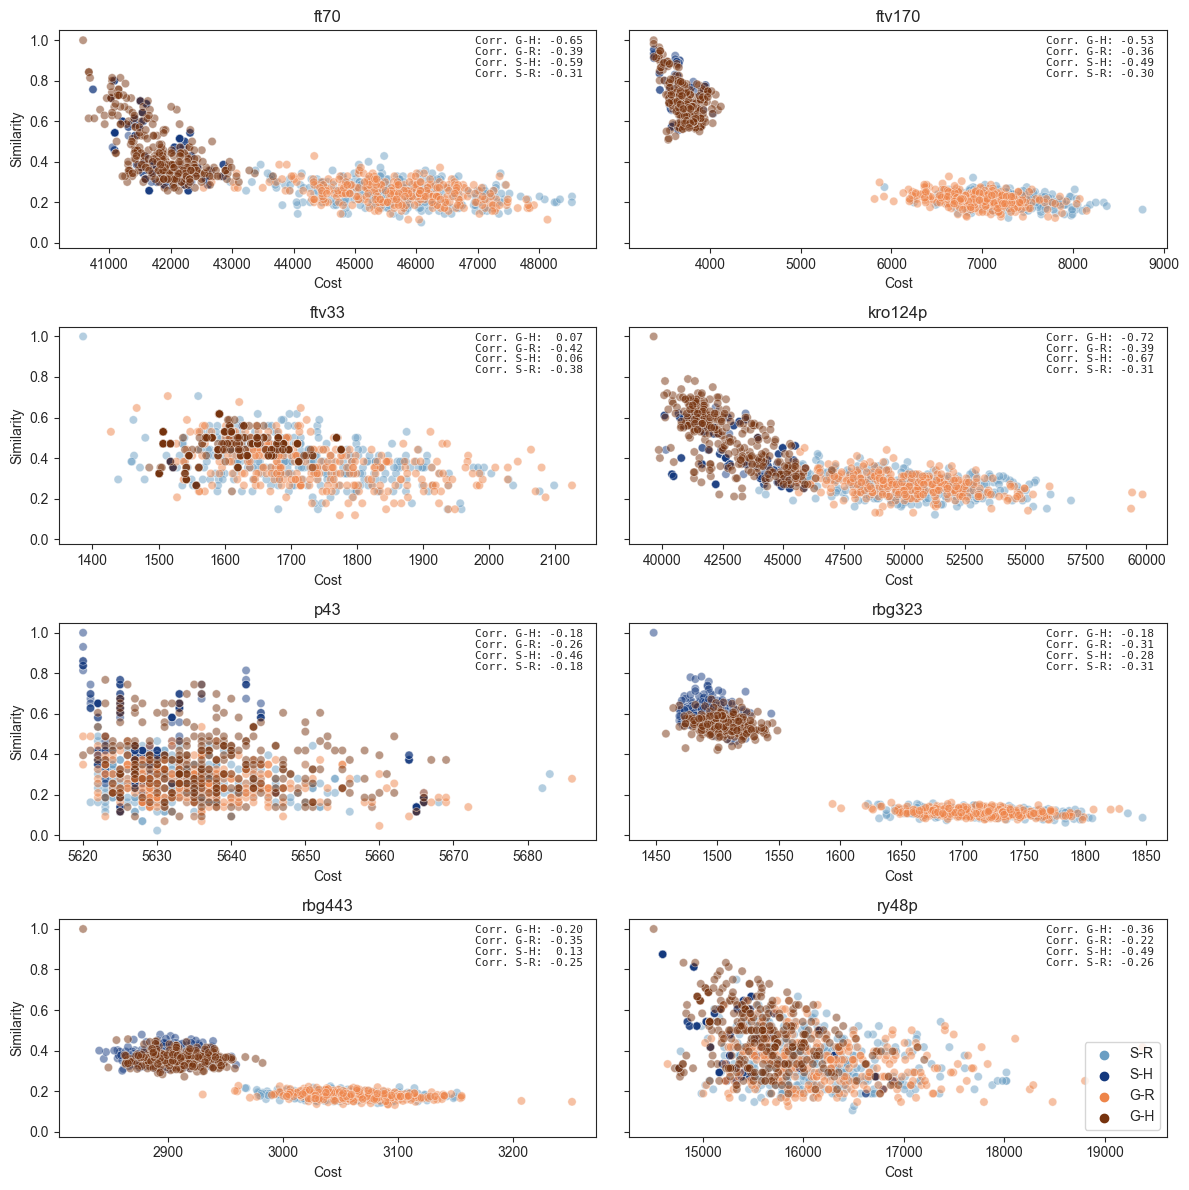

In [32]:
fig, axs = plt.subplots(4, 2, figsize=(12, 12), sharey=True)
sim_correlation_dict = {
    instance: {} for instance in selected_instances
}
for instance, ax in zip(selected_instances, axs.flatten()):
    subset_df = all_res_df[(all_res_df["instance"] == instance) & all_res_df["method"].isin(LS_METHODS + LS_NN_METHODS)]
    sns.scatterplot(
        x='cost',
        y='similarity',
        hue='method',
        data=subset_df,
        ax=ax,
        palette=COLORS,
        alpha=0.5,
    )
    for i, (method, method_df) in enumerate(subset_df.groupby('method')):
        x = method_df['cost']
        y = method_df['similarity']
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        # add box with correlation
        corr_value = np.corrcoef(x, y)[0, 1]
        sim_correlation_dict[instance][method] = corr_value
        text = f"Corr. {(method + ':'):<5}{corr_value:>5.2f}"
        ax.text(0.775, 0.935 - 0.05 * i, text, transform=ax.transAxes, fontsize=8, font="monospace")
    ax.set_title(instance)
    ax.get_legend().remove()
    ax.set_xlabel("Cost")
    ax.set_ylabel("Similarity")

plt.legend(
    loc="lower right"
)
plt.tight_layout()
plt.savefig("plots/1/scatter_cost_similarity.png")
plt.show()

In [33]:
sim_df = pd.DataFrame(sim_correlation_dict).round(2)
sim_df.sort_index(inplace=True)
sim_df

,ft70,ftv170,ftv33,kro124p,p43,rbg323,rbg443,ry48p
G-H,-0.65,-0.53,0.07,-0.72,-0.18,-0.18,-0.20,-0.36
G-R,-0.39,-0.36,-0.42,-0.39,-0.26,-0.31,-0.35,-0.22
S-H,-0.59,-0.49,0.06,-0.67,-0.46,-0.28,0.13,-0.49
S-R,-0.31,-0.30,-0.38,-0.31,-0.18,-0.31,-0.25,-0.26


In [34]:
print(sim_df.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  ft70 &  ftv170 &  ftv33 &  kro124p &   p43 &  rbg323 &  rbg443 &  ry48p \\
\midrule
G-H & -0.65 &   -0.53 &   0.07 &    -0.72 & -0.18 &   -0.18 &   -0.20 &  -0.36 \\
G-R & -0.39 &   -0.36 &  -0.42 &    -0.39 & -0.26 &   -0.31 &   -0.35 &  -0.22 \\
S-H & -0.59 &   -0.49 &   0.06 &    -0.67 & -0.46 &   -0.28 &    0.13 &  -0.49 \\
S-R & -0.31 &   -0.30 &  -0.38 &    -0.31 & -0.18 &   -0.31 &   -0.25 &  -0.26 \\
\bottomrule
\end{tabular}



C:\Users\sbart\AppData\Local\Temp\ipykernel_16996\1728652208.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sim_df.to_latex())


In [35]:
AVG_SIM_PATH = "../data/misc/avg_sim.json"

def mean_similarity(order: list[int], orders: list[list[int]]) -> float:
    return np.mean([similarity(order, o) for o in orders])

if os.path.exists(AVG_SIM_PATH):
    all_res_df["avg_sim"] = pd.read_json(AVG_SIM_PATH)[0]
else:
    all_res_df["avg_sim"] = all_res_df.apply(lambda row: mean_similarity(row["order"], all_res_df[(all_res_df['instance'] == row['instance']) & (all_res_df['cost'] <= row['cost'])].order.to_list()), axis=1)

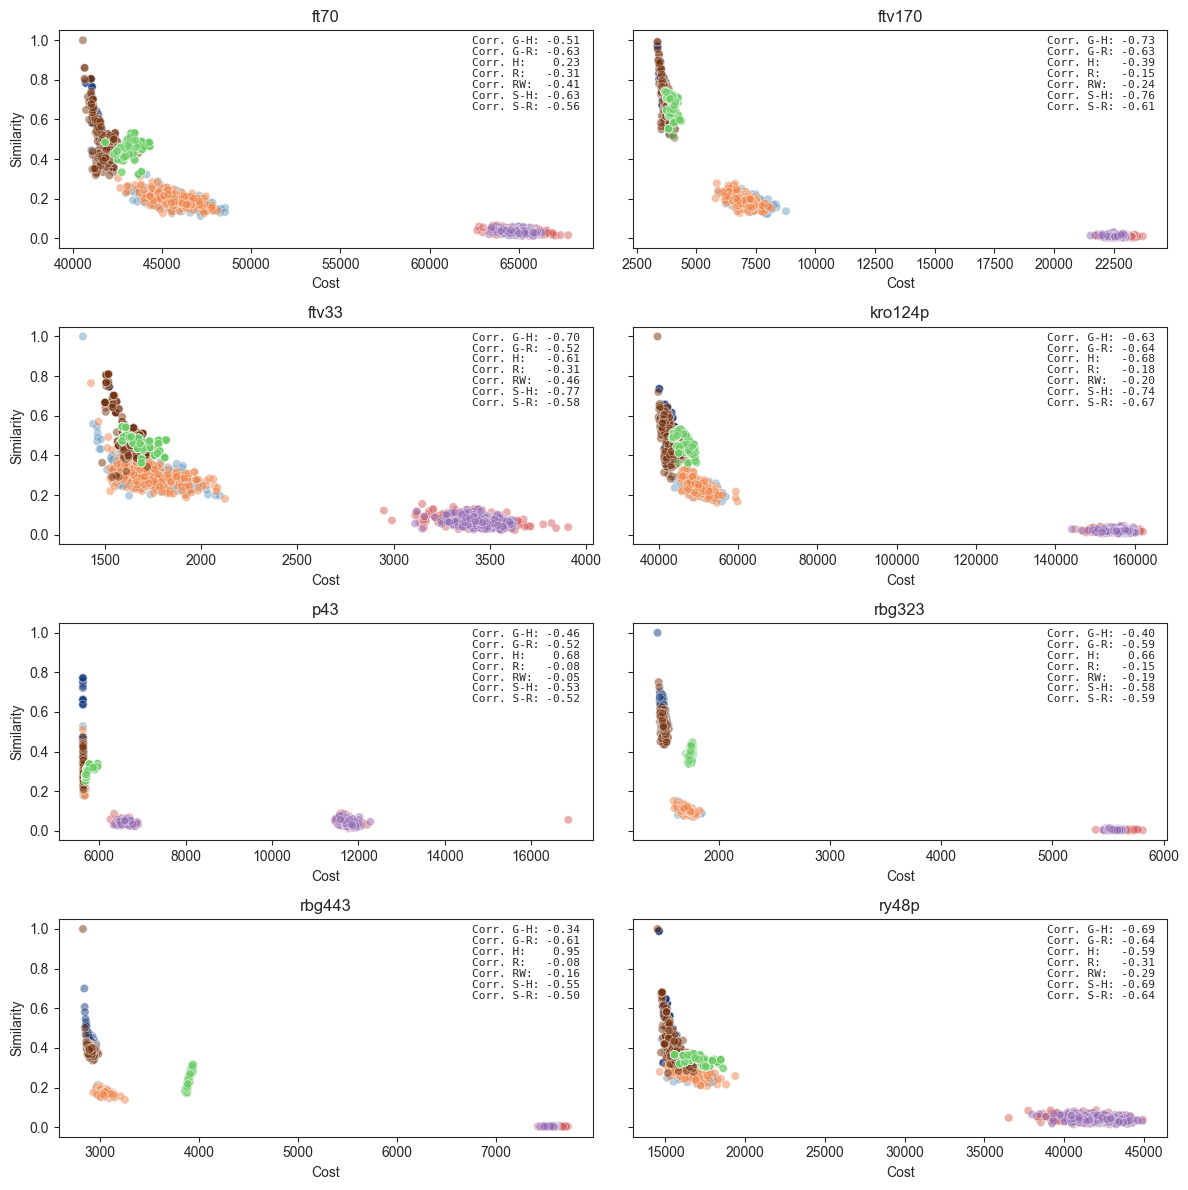

In [36]:
fig, axs = plt.subplots(4, 2, figsize=(12, 12), sharey=True)
avg_sim_correlation_dict = {
    instance: {} for instance in selected_instances
}
for instance, ax in zip(selected_instances, axs.flatten()):
    subset_df = all_res_df[(all_res_df["instance"] == instance)]
    sns.scatterplot(
        x='cost',
        y='avg_sim',
        hue='method',
        data=subset_df,
        ax=ax,
        palette=COLORS,
        alpha=0.5,
    )
    for i, (method, method_df) in enumerate(subset_df.groupby('method')):
        x = method_df['cost']
        y = method_df['avg_sim']
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        # add box with correlation
        corr_value = np.corrcoef(x, y)[0, 1]
        avg_sim_correlation_dict[instance][method] = corr_value
        text = f"Corr. {(method + ':'):<5}{corr_value:>5.2f}"
        ax.text(0.775, 0.935 - 0.05 * i, text, transform=ax.transAxes, fontsize=8, font="monospace")
    ax.set_title(instance)
    ax.get_legend().remove()
    ax.set_xlabel("Cost")
    ax.set_ylabel("Similarity")
    # ax.set_xscale('log')

plt.tight_layout()
plt.savefig("plots/1/scatter_cost_avg_similarity.png")
plt.show()

In [37]:
avg_sim_df = pd.DataFrame(avg_sim_correlation_dict).round(2)
avg_sim_df.sort_index(inplace=True)
avg_sim_df

,ft70,ftv170,ftv33,kro124p,p43,rbg323,rbg443,ry48p
G-H,-0.51,-0.73,-0.70,-0.63,-0.46,-0.40,-0.34,-0.69
G-R,-0.63,-0.63,-0.52,-0.64,-0.52,-0.59,-0.61,-0.64
H,0.23,-0.39,-0.61,-0.68,0.68,0.66,0.95,-0.59
R,-0.31,-0.15,-0.31,-0.18,-0.08,-0.15,-0.08,-0.31
RW,-0.41,-0.24,-0.46,-0.20,-0.05,-0.19,-0.16,-0.29
S-H,-0.63,-0.76,-0.77,-0.74,-0.53,-0.58,-0.55,-0.69
S-R,-0.56,-0.61,-0.58,-0.67,-0.52,-0.59,-0.50,-0.64


In [38]:
print(avg_sim_df.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  ft70 &  ftv170 &  ftv33 &  kro124p &   p43 &  rbg323 &  rbg443 &  ry48p \\
\midrule
G-H & -0.51 &   -0.73 &  -0.70 &    -0.63 & -0.46 &   -0.40 &   -0.34 &  -0.69 \\
G-R & -0.63 &   -0.63 &  -0.52 &    -0.64 & -0.52 &   -0.59 &   -0.61 &  -0.64 \\
H   &  0.23 &   -0.39 &  -0.61 &    -0.68 &  0.68 &    0.66 &    0.95 &  -0.59 \\
R   & -0.31 &   -0.15 &  -0.31 &    -0.18 & -0.08 &   -0.15 &   -0.08 &  -0.31 \\
RW  & -0.41 &   -0.24 &  -0.46 &    -0.20 & -0.05 &   -0.19 &   -0.16 &  -0.29 \\
S-H & -0.63 &   -0.76 &  -0.77 &    -0.74 & -0.53 &   -0.58 &   -0.55 &  -0.69 \\
S-R & -0.56 &   -0.61 &  -0.58 &    -0.67 & -0.52 &   -0.59 &   -0.50 &  -0.64 \\
\bottomrule
\end{tabular}



C:\Users\sbart\AppData\Local\Temp\ipykernel_16996\3336165821.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(avg_sim_df.to_latex())
